In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

# import dask
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()  # Launches a scheduler and workers locally
# client = Client(cluster)  # Connect to distributed cluster and override default
# dask.config.set(scheduler='threads')

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import os
from IPython.core.debugger import set_trace
import pandas as pd

category =  "config3"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

u_bulk is 2.6803574256411156
domain height is 116.0
u_bulk is 2.6836620775473787
domain height is 116.0


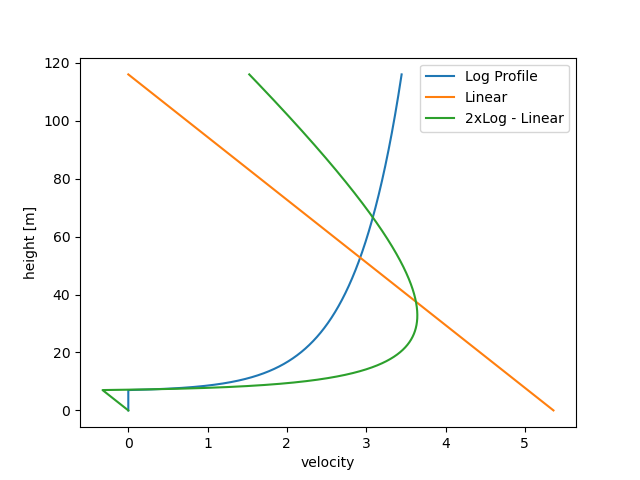

In [33]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
# Lz =  24*hm*4/3/3
Lx = 348
Lz = Lx / 3
z_ref = 10 # really y_refj
U_ref = 2

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

physics_setup.plot_spinup_velocity()
physics_setup.plot_spinup_velocity2()

plt.legend()

plt.show()

In [20]:
display(
    physics_setup.LES_params['uStar'], 
    physics_setup.LES_params['z0'], 
    physics_setup.LES_params['disp'], 
    physics_setup.LES_params['u_bulk'],
    physics_setup.LES_params['log_wind'][-1]
    )

0.4958117453795493

0.366

6.66

5.3673241550947575

6.892489779268227

In [21]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )

U infinity is 6.892489779268227 with L = 116.0
flat plate Reynolds number is 54690022.84674305
wall spacing is 0.03320901041463975 for y+ of 500


In [22]:
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)


In [23]:
# start = -25000#-250000
# stop = -1000
by = 1
start = 1000
stop = -1

# Run Specifics

In [24]:
run = 3
qois = ['comp(u,0)']

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'


In [25]:
probes = probePost.Probes(probes_dir, file_type = "csv")
probes.to_parquet(overwrite=True)

probes = probePost.Probes(probes_dir, file_type = "parquet")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bz.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bx.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bz.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bx.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bz.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bz.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bx.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bx.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bx.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bz.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bx.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bxz.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bx.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bxz.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bxz.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bz.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bx.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bx.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bz.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bxz.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bxz.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bz.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bxz.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bxz.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bxz.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bx.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bz.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bx.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bxz.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bz.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0_Bx.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bxz.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n1_Bz.comp(u,0).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-0.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bxz.comp(u,2).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bz.p.parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2_Bxz.comp(u,1).parquet took 1 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/pyarrow/pandas_compat.py:456: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


writing /scratch/users/nbachand/Cascade/city_block_cfd/CHARLES/config3/R3/probes/probesOut/../probesOut_parquet/col_0-n2.p.parquet took 1 seconds


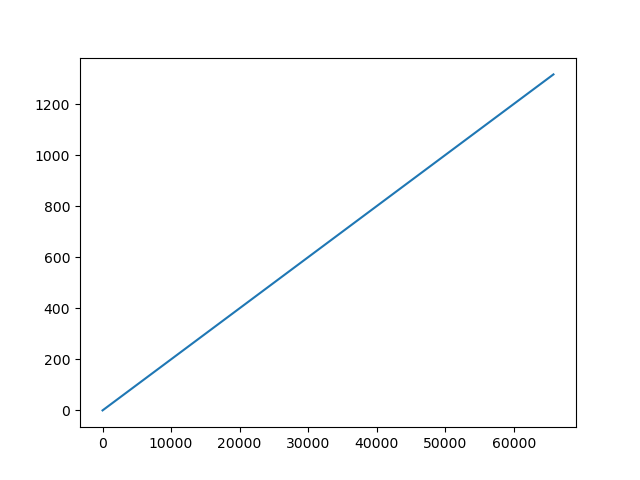

In [26]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

processing data took 1 seconds
plotting took 4 seconds


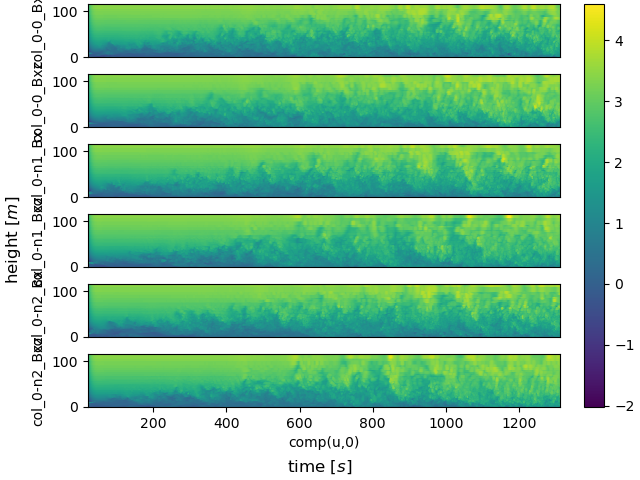

In [36]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : probes.probe_times,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1,
    'plot_every': 100
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "Bx" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    parrallel = True,
    plot_params = plot_params
#     processing = [norm_vel]
    )

plt.show()

In [28]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

processing data took 2 seconds


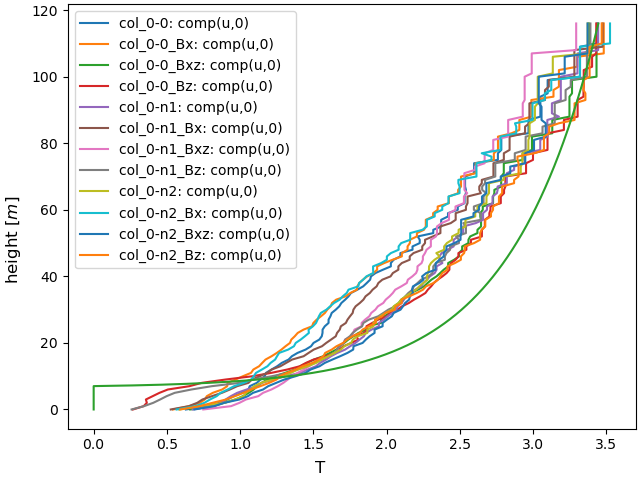

In [39]:
probes.profile_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[stop-30000:stop:by],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'T',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [30]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

processing data took 3 seconds


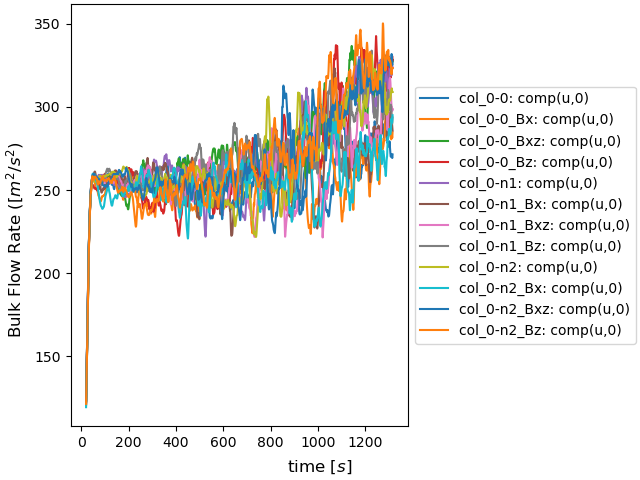

In [31]:
@utils.no_kwargs
def bulk_flow(data_dict, tdata = None):
    for k, v in data_dict.items():
        name, _ = k
        y_loc = probes.locations[name]['y']
        net_flow = np.trapz(v, y_loc, axis = 1)
        data_dict[k] = pd.DataFrame(net_flow, index = v.index)
    return data_dict

by = 1

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Bulk Flow Rate ($[m^2/s^2$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [bulk_flow],
    parrallel=True
    )



In [32]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/bulk_flow')